In [2]:
import sys

sys.path.append("../")

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

# import data.drawings.make_tasks as drawing_tasks
from src.analysis_utilities import SynthesisExperimentAnalyzer
from src.config_builder import ExperimentType

/opt/conda/envs/lilo/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
sns.set_theme(style="whitegrid", font_scale=1.25, rc={'figure.figsize':(12, 8)})

In [6]:
%config InlineBackend.figure_format = 'retina'

In [7]:
EXPERIMENT_NAME = "runs_human_2"

COMPUTE_LIKELIHOODS = True

FIGURES_DIR = os.path.join("figures", EXPERIMENT_NAME)
os.makedirs(FIGURES_DIR, exist_ok=True)

In [8]:
analyzer = SynthesisExperimentAnalyzer(
    experiment_name=EXPERIMENT_NAME,
    experiment_types=["baseline_dreamcoder", "gpt_solver", "gpt_solver_stitch", "gpt_solver_stitch_namer", "gpt_solver_stitch_namer_hybrid_dsl", "gpt_solver_stitch_namer_search"],
    allow_incomplete_results=True,
    compute_likelihoods=COMPUTE_LIKELIHOODS,
    batch_size = 96,
    seeds = [111, 222, 333],
)

Experiment directory: ../experiments_iterative/outputs/runs_human_2
Available domains: ['re2_human', 'clevr_human', 'logo_human']


# Tasks solved vs. LAPS iteration

In [9]:
df_results = analyzer.get_synthesis_summary()
df_results = analyzer.format_dataframe_camera(df_results)

In [10]:
df_results

,domain,Model,seed,iteration,split,n_solved,Tasks solved (%)
339,REGEX (human language),DreamCoder,111,0,test,101,20.2
343,REGEX (human language),DreamCoder,111,3,test,206,41.2
347,REGEX (human language),DreamCoder,111,6,test,229,45.8
351,REGEX (human language),DreamCoder,111,9,test,247,49.4
355,REGEX (human language),DreamCoder,111,12,test,249,49.8
...,...,...,...,...,...,...,...
332,LOGO (human language),LILO (+ Search),333,5,train,59,29.5
334,LOGO (human language),LILO (+ Search),333,6,train,65,32.5
335,LOGO (human language),LILO (+ Search),333,7,train,69,34.5
336,LOGO (human language),LILO (+ Search),333,8,train,78,39.0


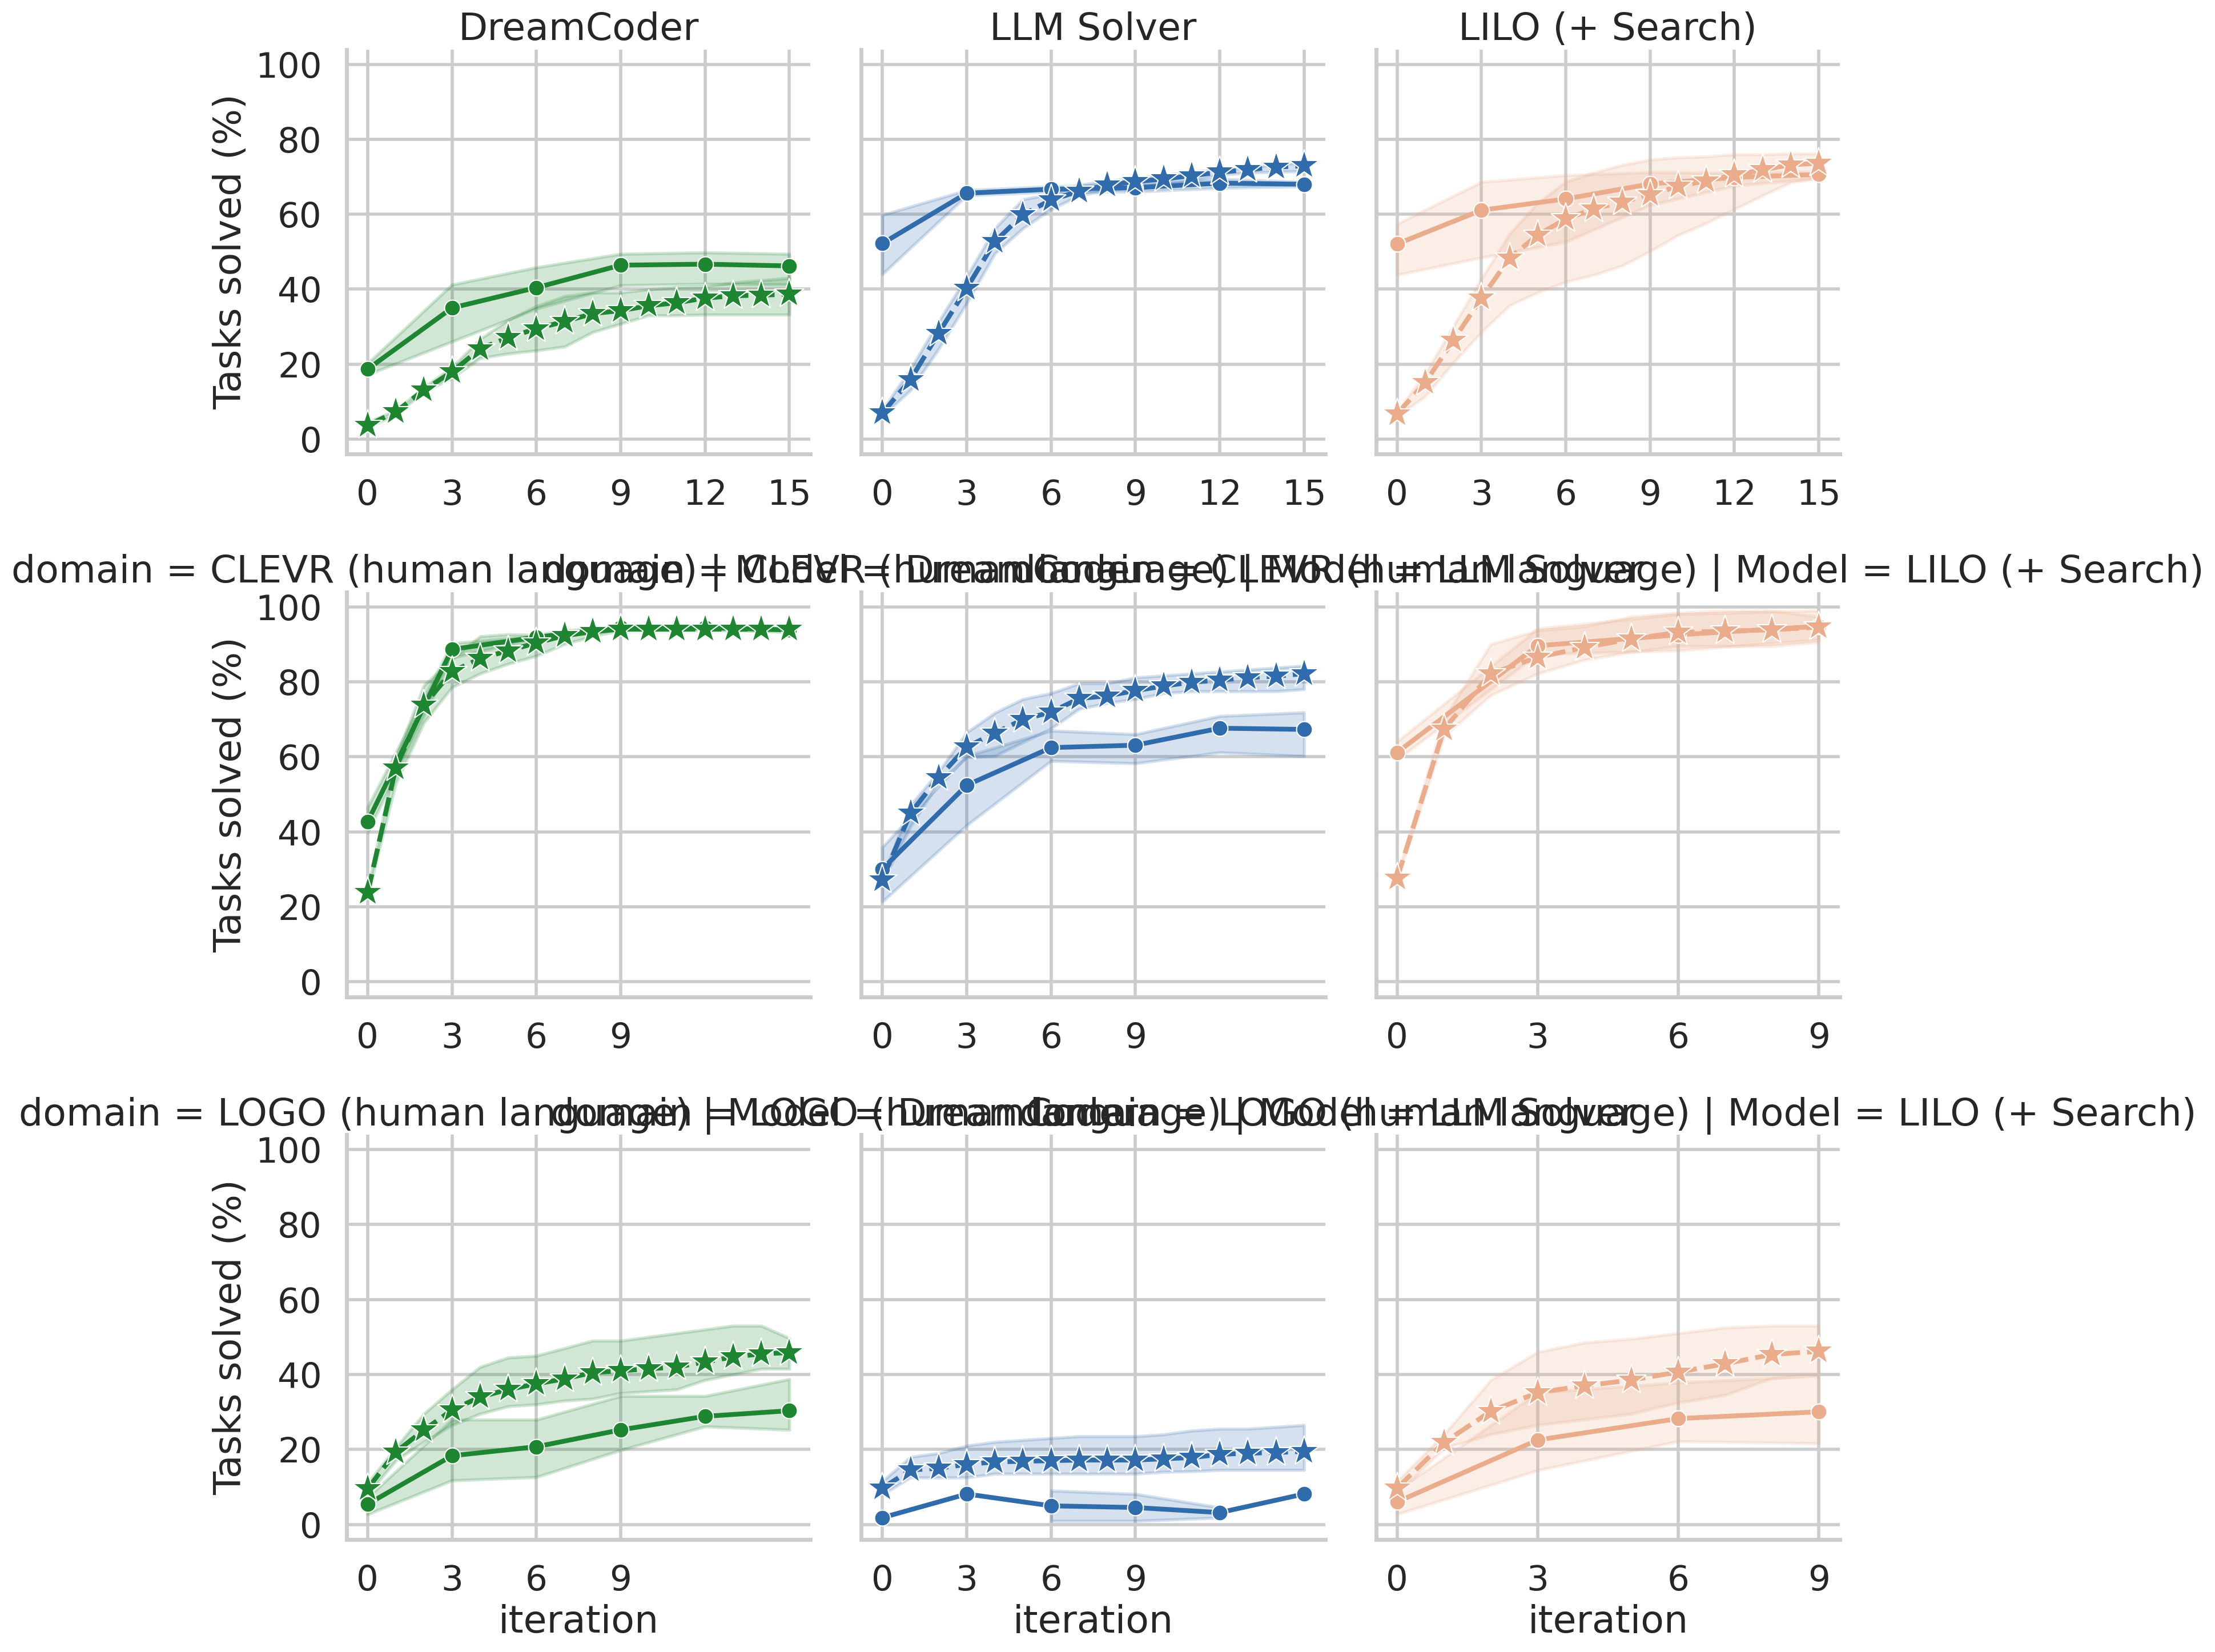

In [27]:
with sns.plotting_context("poster", font_scale=1):
    g = sns.relplot(
        data=df_results,
        kind="line",
        row="domain",
        col=analyzer.COL_NAMES_CAMERA["experiment_type"],
        x="iteration",
        y=analyzer.COL_NAMES_CAMERA["percent_solved"],
        hue=analyzer.COL_NAMES_CAMERA["experiment_type"],
        style="split",
        markers=[".", "*"],
        markersize=20,
        # errorbar="se",
        # col_order=["train", "test"],
        row_order = [d for d in list(analyzer.DOMAIN_NAMES_CAMERA.values()) if d in list(df_results["domain"])],
        facet_kws={'sharex': False, 'sharey': True, 'margin_titles': False},
        palette=analyzer.EXPERIMENT_TYPES_PALETTE,
        legend=False,
    )
    for subplot in g.axes[0]:
        subplot.set_title(subplot.title.get_text().split(" = ")[-1])
        
    for ax in g.axes[0]:
        ax.set_xticks(np.arange(0, 16, 3))
    for ax in g.axes[1]:
        ax.set_xticks(np.arange(0, 10, 3))
    for ax in g.axes[2]:
        ax.set_xticks(np.arange(0, 10, 3))
        
    # sns.move_legend(g, "lower center")
        
    # plt.savefig(os.path.join(FIGURES_DIR, "main_results.pdf"), dpi=300, bbox_inches="tight")

# Main results table

In [69]:
df_results_test = df_results.query("split == 'test'")
grouped = df_results_test.groupby([
    "domain",
    analyzer.COL_NAMES_CAMERA["experiment_type"],
    "seed",
], as_index=False)

def _get_final_iteration(group):
    final_iteration = group["iteration"].max().item()
    return group[group["iteration"] == final_iteration]

df_results_test = grouped.apply(_get_final_iteration).reset_index(drop=True)
df_results_test

,domain,Model,seed,iteration,split,n_solved,Tasks solved (%)
0,REGEX,DreamCoder,111,15,test,228,45.600000
1,REGEX,DreamCoder,222,15,test,213,42.600000
2,REGEX,DreamCoder,333,15,test,218,43.600000
3,REGEX,LLM Solver,111,15,test,350,70.000000
4,REGEX,LLM Solver,222,15,test,450,90.000000
5,REGEX,LLM Solver,333,15,test,342,68.400000
6,REGEX,LLM Solver (+ Stitch),111,15,test,249,49.800000
7,REGEX,LLM Solver (+ Stitch),222,15,test,252,50.400000
8,REGEX,LLM Solver (+ Stitch),333,15,test,297,59.400000
9,REGEX,LILO,111,15,test,319,63.800000


In [70]:
df_metrics_test = df_results_test.groupby([
    "domain",
    analyzer.COL_NAMES_CAMERA["experiment_type"],
]) \
[[
    analyzer.COL_NAMES_CAMERA["percent_solved"]
]] \
.agg(["mean", "max", "std"])

df_metrics_test = df_metrics_test.reindex(list(analyzer.DOMAIN_NAMES_CAMERA.values()), level=0)
df_metrics_test

Tasks solved (%)                      
                                         mean        max        std
domain Model                                                       
REGEX  DreamCoder                   43.933333  45.600000   1.527525
       LLM Solver                   76.133333  90.000000  12.035503
       LLM Solver (+ Stitch)        53.200000  59.400000   5.377732
       LILO                         62.933333  63.800000   1.501111
       LILO (+ Hybrid DSL)          64.533333  69.600000   7.759725
       LILO (+ Search)              77.066667  93.200000  14.144021
CLEVR  DreamCoder                   94.498382  97.087379   2.443312
       LLM Solver                   88.673139  90.291262   1.483034
       LLM Solver (+ Stitch)        85.760518  93.203883   9.724906
       LILO                         88.025890  94.174757   8.257185
       LILO (+ Hybrid DSL)          90.938511  94.174757   3.409597
       LILO (+ Search)              96.763754  99.029126   3.120923
LOGO   DreamCoder                   28.528529  36.936937  13.790946
       LLM Solver                   32.132132  41.441441   8.074672
       LLM Solver (+ Stitch)        21.021021  45.045045  20.883290
       LILO                         21.021021  30.630631   9.463034
       LILO (+ Hybrid DSL)          32.432432  40.540541   7.036261
       LILO (+ Search)              48.948949  73.873874  22.147020

In [71]:
# Reorder column levels
df_metrics_test_final = df_metrics_test.reset_index().pivot(index="Model", columns="domain").reorder_levels(order=[0, 2, 1], axis="columns")

# Reorder columns
multiindex = df_metrics_test_final.columns
multiindex = multiindex.reindex(list(analyzer.DOMAIN_NAMES_CAMERA.values()), level=1)[0]
multiindex = multiindex.reindex(["max", "mean", "std"], level=2)[0]

df_metrics_test_final = df_metrics_test_final.reindex(columns=multiindex)
df_metrics_test_final.columns.names = [None, None, None]

# Reorder rows
experiment_types = [x for x in analyzer.EXPERIMENT_TYPES_CAMERA.values() if x in df_metrics_test_final.index]
df_metrics_test_final = df_metrics_test_final.reindex(experiment_types)

# Remove 'Model'
df_metrics_test_final.index.name = None

# Round numbers
df_metrics_test_final = df_metrics_test_final.round(2)

# Output to LaTeX
df_metrics_test_final.to_latex("main_results_table.tex")

df_metrics_test_final

Tasks solved (%)                                    \
                                 REGEX                CLEVR                
                                   max   mean    std    max   mean   std   
DreamCoder                        45.6  43.93   1.53  97.09  94.50  2.44   
LLM Solver                        90.0  76.13  12.04  90.29  88.67  1.48   
LLM Solver (+ Stitch)             59.4  53.20   5.38  93.20  85.76  9.72   
LILO                              63.8  62.93   1.50  94.17  88.03  8.26   
LILO (+ Hybrid DSL)               69.6  64.53   7.76  94.17  90.94  3.41   
LILO (+ Search)                   93.2  77.07  14.14  99.03  96.76  3.12   

                                            
                        LOGO                
                         max   mean    std  
DreamCoder             36.94  28.53  13.79  
LLM Solver             41.44  32.13   8.07  
LLM Solver (+ Stitch)  45.05  21.02  20.88  
LILO                   30.63  21.02   9.46  
LILO (+ Hybrid DSL)    40.54  32.43   7.04  
LILO (+ Search)        73.87  48.95  22.15

# Runtime metrics

In [72]:
df_runtime = analyzer.get_runtime_metrics()
df_runtime.groupby(["domain", "experiment_type", "model_type", "model_fn", "split"]).time_elapsed.agg("mean")

domain  experiment_type                     model_type           model_fn                      split
clevr   baseline_dreamcoder                 amortized_synthesis  infer_programs_for_tasks      test      627.410529
                                                                                               train     626.392419
                                                                 optimize_model_for_frontiers  train     639.112597
                                            grammar              infer_programs_for_tasks      train     602.131269
        gpt_solver                          llm_solver           infer_programs_for_tasks      test      754.704399
                                                                                               train     717.473114
        gpt_solver_stitch                   llm_solver           infer_programs_for_tasks      test      599.403698
                                                                                       

In [73]:
df_infer_programs = df_runtime.query("model_fn == 'infer_programs_for_tasks'").query("model_type != 'grammar'")

# Remove outliers
df_infer_programs = df_infer_programs.query("time_elapsed > 300.0")


df_infer_programs

,curr_iteration,model_type,model_fn,split,time_start,time_end,time_elapsed,domain,experiment_type,seed,iteration
1,0,amortized_synthesis,infer_programs_for_tasks,train,2023-04-28 22:24:19.571785472+00:00,2023-04-28 22:41:05.207317504+00:00,1005.635532,re2,baseline_dreamcoder,111,0
2,0,amortized_synthesis,infer_programs_for_tasks,test,2023-04-28 22:41:05.210528768+00:00,2023-04-29 00:08:40.567719168+00:00,5255.357190,re2,baseline_dreamcoder,111,0
4,1,amortized_synthesis,infer_programs_for_tasks,train,2023-04-29 00:13:29.896112384+00:00,2023-04-29 00:30:25.199052032+00:00,1015.302940,re2,baseline_dreamcoder,111,1
6,2,amortized_synthesis,infer_programs_for_tasks,train,2023-04-29 00:34:49.866311680+00:00,2023-04-29 00:51:45.249414912+00:00,1015.383103,re2,baseline_dreamcoder,111,2
8,3,amortized_synthesis,infer_programs_for_tasks,train,2023-04-29 00:56:06.303152384+00:00,2023-04-29 01:13:01.237486592+00:00,1014.934334,re2,baseline_dreamcoder,111,3
...,...,...,...,...,...,...,...,...,...,...,...
1589,8,amortized_synthesis,infer_programs_for_tasks,train,2023-05-09 15:56:04.268782336+00:00,2023-05-09 16:26:23.548738560+00:00,1819.279956,logo,gpt_solver_stitch_namer_search,333,8
1591,9,llm_solver,infer_programs_for_tasks,train,2023-05-09 19:46:34.041540352+00:00,2023-05-09 19:55:45.109794304+00:00,551.068254,logo,gpt_solver_stitch_namer_search,333,9
1593,9,amortized_synthesis,infer_programs_for_tasks,train,2023-05-09 20:02:59.027871488+00:00,2023-05-09 20:33:13.493095424+00:00,1814.465224,logo,gpt_solver_stitch_namer_search,333,9
1594,9,llm_solver,infer_programs_for_tasks,test,2023-05-09 20:33:13.494556160+00:00,2023-05-09 20:46:42.105857024+00:00,808.611301,logo,gpt_solver_stitch_namer_search,333,9


In [74]:
analyzer.format_dataframe_camera(df_infer_programs)

,curr_iteration,model_type,model_fn,split,time_start,time_end,time_elapsed,domain,Model,seed,iteration
2,0,amortized_synthesis,infer_programs_for_tasks,test,2023-04-28 22:41:05.210528768+00:00,2023-04-29 00:08:40.567719168+00:00,5255.357190,REGEX,DreamCoder,111,0
9,3,amortized_synthesis,infer_programs_for_tasks,test,2023-04-29 01:13:01.245009920+00:00,2023-04-29 02:29:59.210052352+00:00,4617.965042,REGEX,DreamCoder,111,3
16,6,amortized_synthesis,infer_programs_for_tasks,test,2023-04-29 03:33:58.367144192+00:00,2023-04-29 04:41:22.761961472+00:00,4044.394817,REGEX,DreamCoder,111,6
23,9,amortized_synthesis,infer_programs_for_tasks,test,2023-04-29 05:46:13.461995008+00:00,2023-04-29 06:52:22.957523456+00:00,3969.495528,REGEX,DreamCoder,111,9
30,12,amortized_synthesis,infer_programs_for_tasks,test,2023-04-29 07:57:26.422527488+00:00,2023-04-29 08:59:17.856697088+00:00,3711.434170,REGEX,DreamCoder,111,12
...,...,...,...,...,...,...,...,...,...,...,...
1585,7,amortized_synthesis,infer_programs_for_tasks,train,2023-05-09 14:55:19.712157952+00:00,2023-05-09 15:25:40.473774592+00:00,1820.761617,LOGO,LILO (+ Search),333,7
1587,8,llm_solver,infer_programs_for_tasks,train,2023-05-09 15:27:17.377997824+00:00,2023-05-09 15:36:32.525122048+00:00,555.147124,LOGO,LILO (+ Search),333,8
1589,8,amortized_synthesis,infer_programs_for_tasks,train,2023-05-09 15:56:04.268782336+00:00,2023-05-09 16:26:23.548738560+00:00,1819.279956,LOGO,LILO (+ Search),333,8
1591,9,llm_solver,infer_programs_for_tasks,train,2023-05-09 19:46:34.041540352+00:00,2023-05-09 19:55:45.109794304+00:00,551.068254,LOGO,LILO (+ Search),333,9


## Wall clock time figure

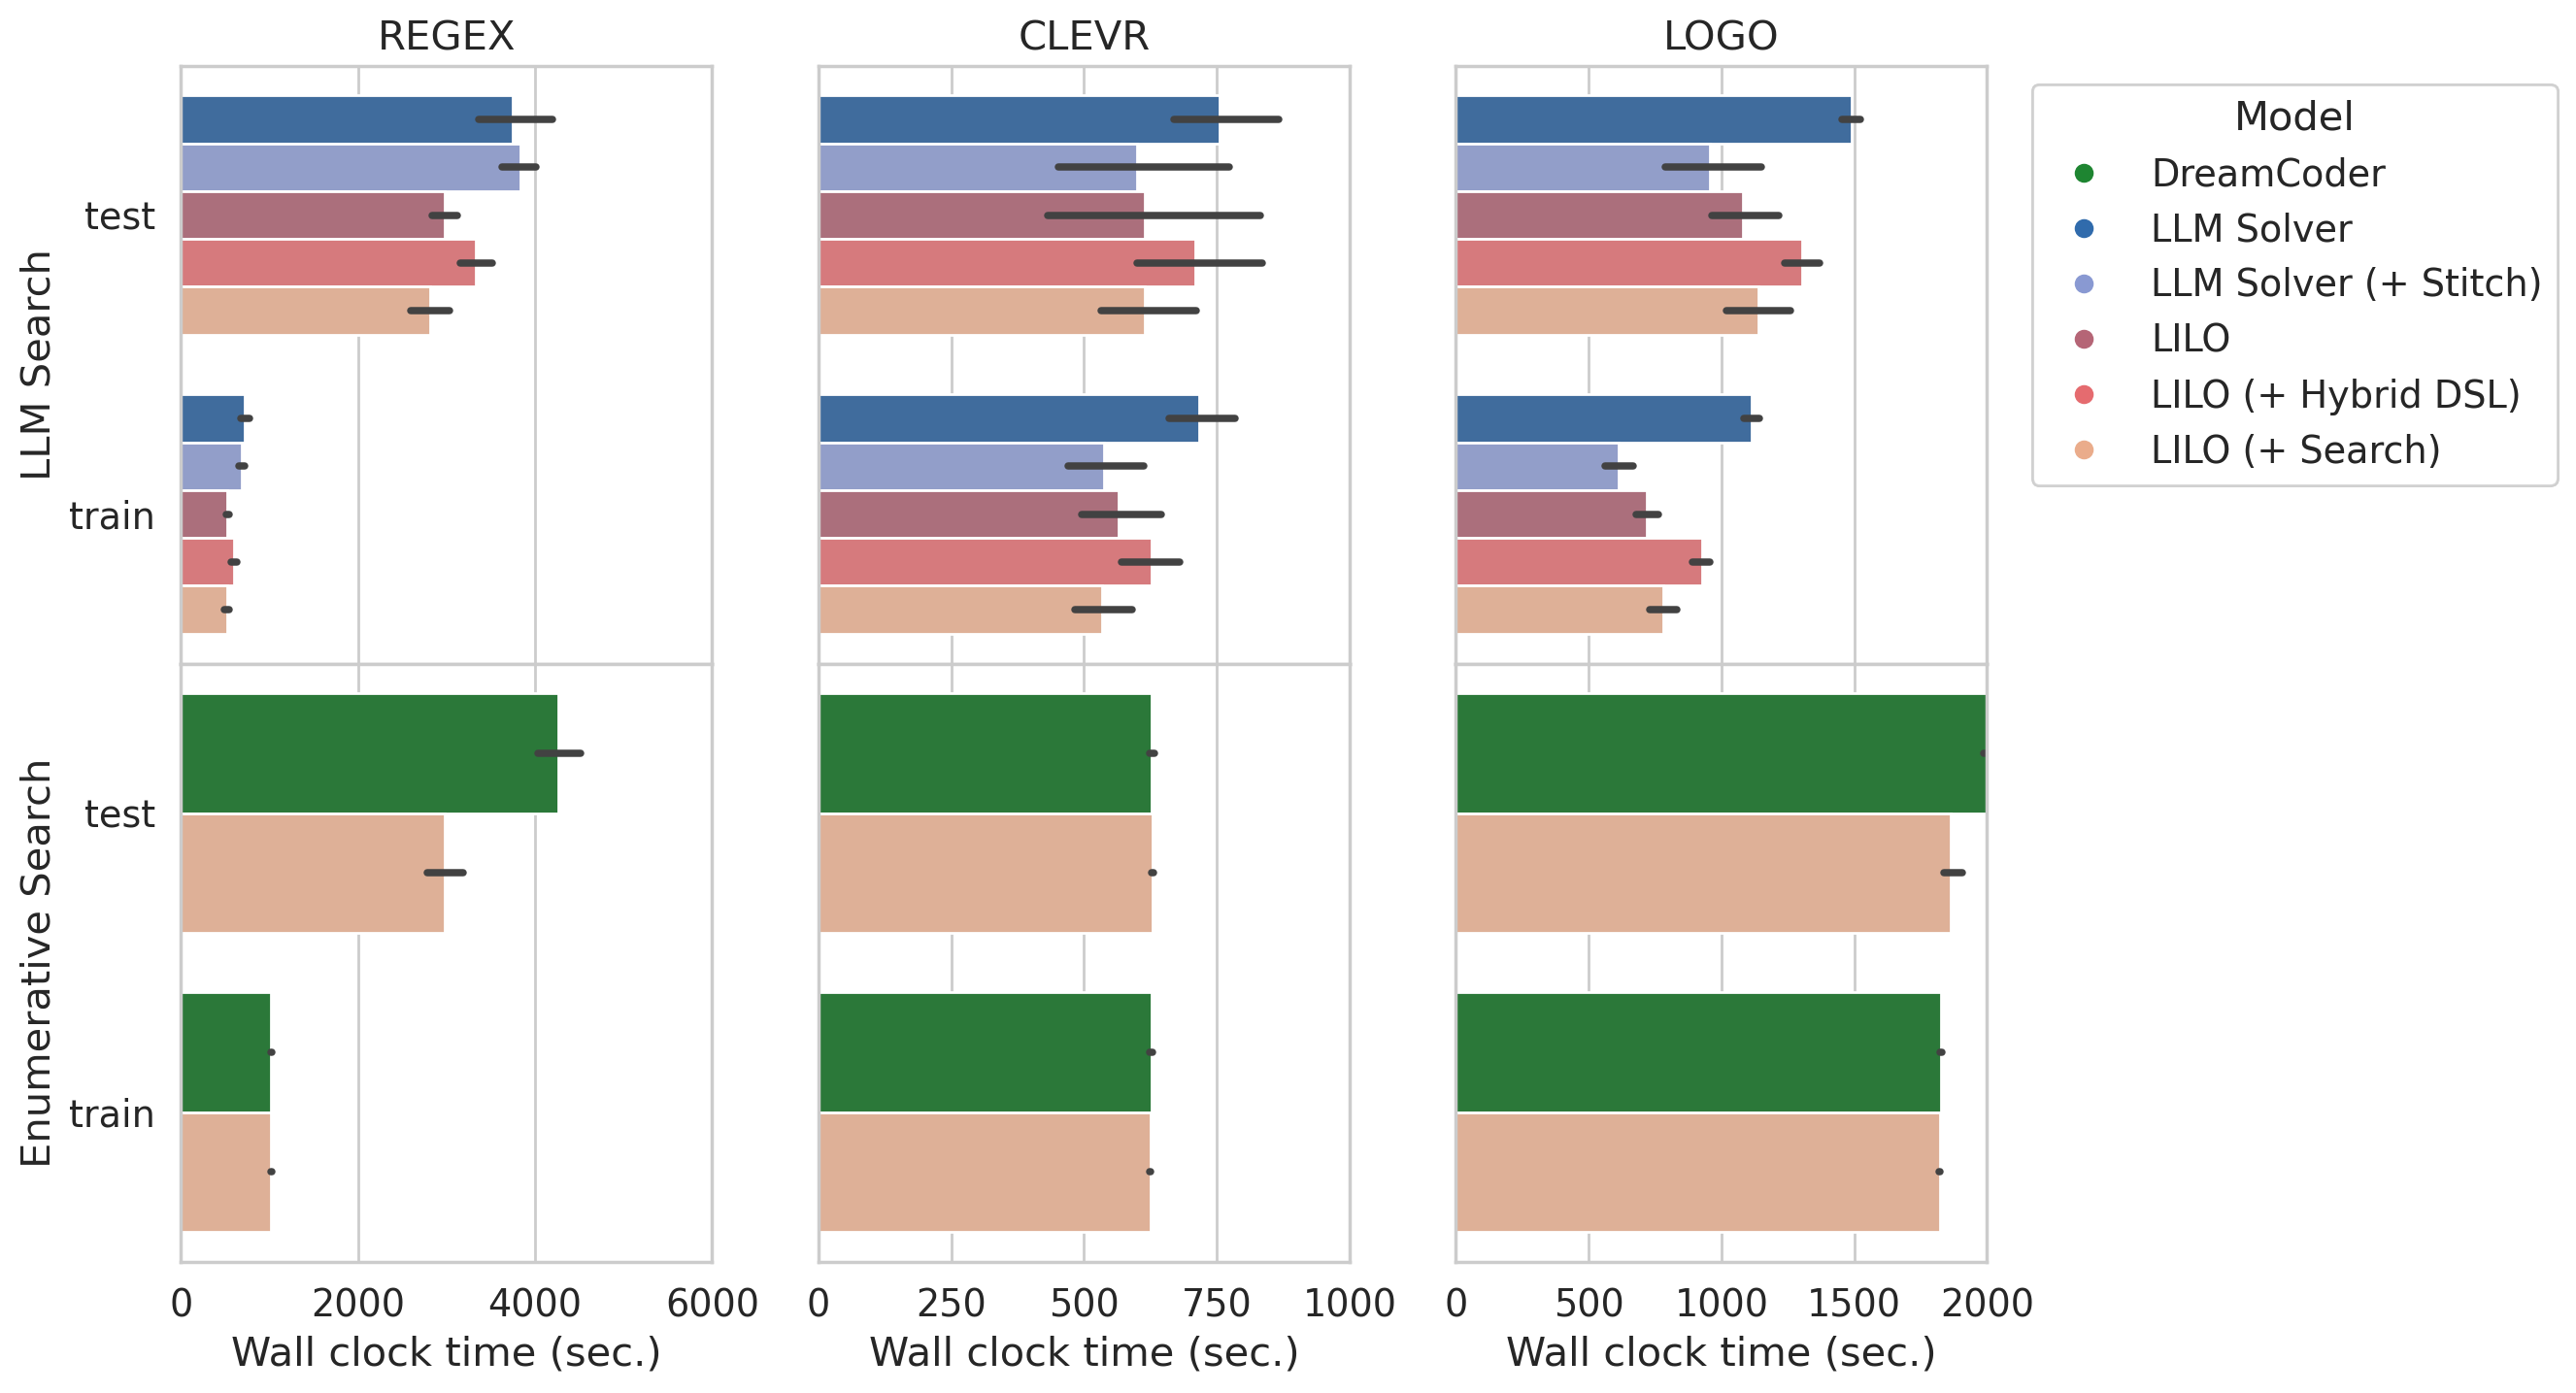

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

# First plot
fig, axes = plt.subplots(nrows=2, ncols=3, sharex=False)  # Create subplots with shared x-axis
plt.subplots_adjust(hspace=0.)  # Adjust vertical spacing between subplots

for i, domain in enumerate(analyzer.DOMAIN_NAMES_CAMERA.keys()):

    # Plot 1
    ax1 = sns.barplot(
        data=analyzer.format_dataframe_camera(df_infer_programs.query("model_type == 'llm_solver'").query(f"domain == '{domain}'")), 
        ax=axes[0][i],  # Specify the first subplot
        y="split",
        x="time_elapsed", 
        hue=analyzer.COL_NAMES_CAMERA["experiment_type"],
        palette=analyzer.EXPERIMENT_TYPES_PALETTE,
    )
    ax1.set(xlabel=None)
    ax1.set_xticks(ticks=ax1.get_xticks(), labels=[])
    
    ax1.legend_.remove()
    
    ax1.set_title(analyzer.DOMAIN_NAMES_CAMERA[domain])

    # Plot 2
    ax2 = sns.barplot(
        data=analyzer.format_dataframe_camera(df_infer_programs.query("model_type == 'amortized_synthesis'").query(f"domain == '{domain}'")), 
        ax=axes[1][i],  # Specify the second subplot
        y="split",
        x="time_elapsed", 
        hue=analyzer.COL_NAMES_CAMERA["experiment_type"],
        palette=analyzer.EXPERIMENT_TYPES_PALETTE,
    )
    
    ax2.set(xlabel="Wall clock time (sec.)", xlim=ax1.get_xlim())
    
    ax2.legend_.remove()
    
    
    
    # Remove y-axis labels and ticks for plots except the first row
    if i==0:
        ax1.set_ylabel("LLM Search")
        ax2.set_ylabel("Enumerative Search")
    else:
        ax1.set(ylabel=None)
        ax2.set(ylabel=None)
        ax1.set_yticks([])
        ax2.set_yticks([])

# Create a legend outside the figure
legend_labels = list(analyzer.EXPERIMENT_TYPES_CAMERA.values())[1:]
legend_handles = [plt.Line2D([], [], color=color, marker='o', linestyle='') for color in list(analyzer.EXPERIMENT_TYPES_PALETTE.values())[1:]]
legend = ax1.legend(legend_handles, legend_labels, title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')

# Add the legend to the figure
fig.add_artist(legend)

# Save figure
plt.savefig(os.path.join(FIGURES_DIR, "wall_clock_time.pdf"), dpi=300, bbox_inches="tight")

# Show the plots
plt.show()

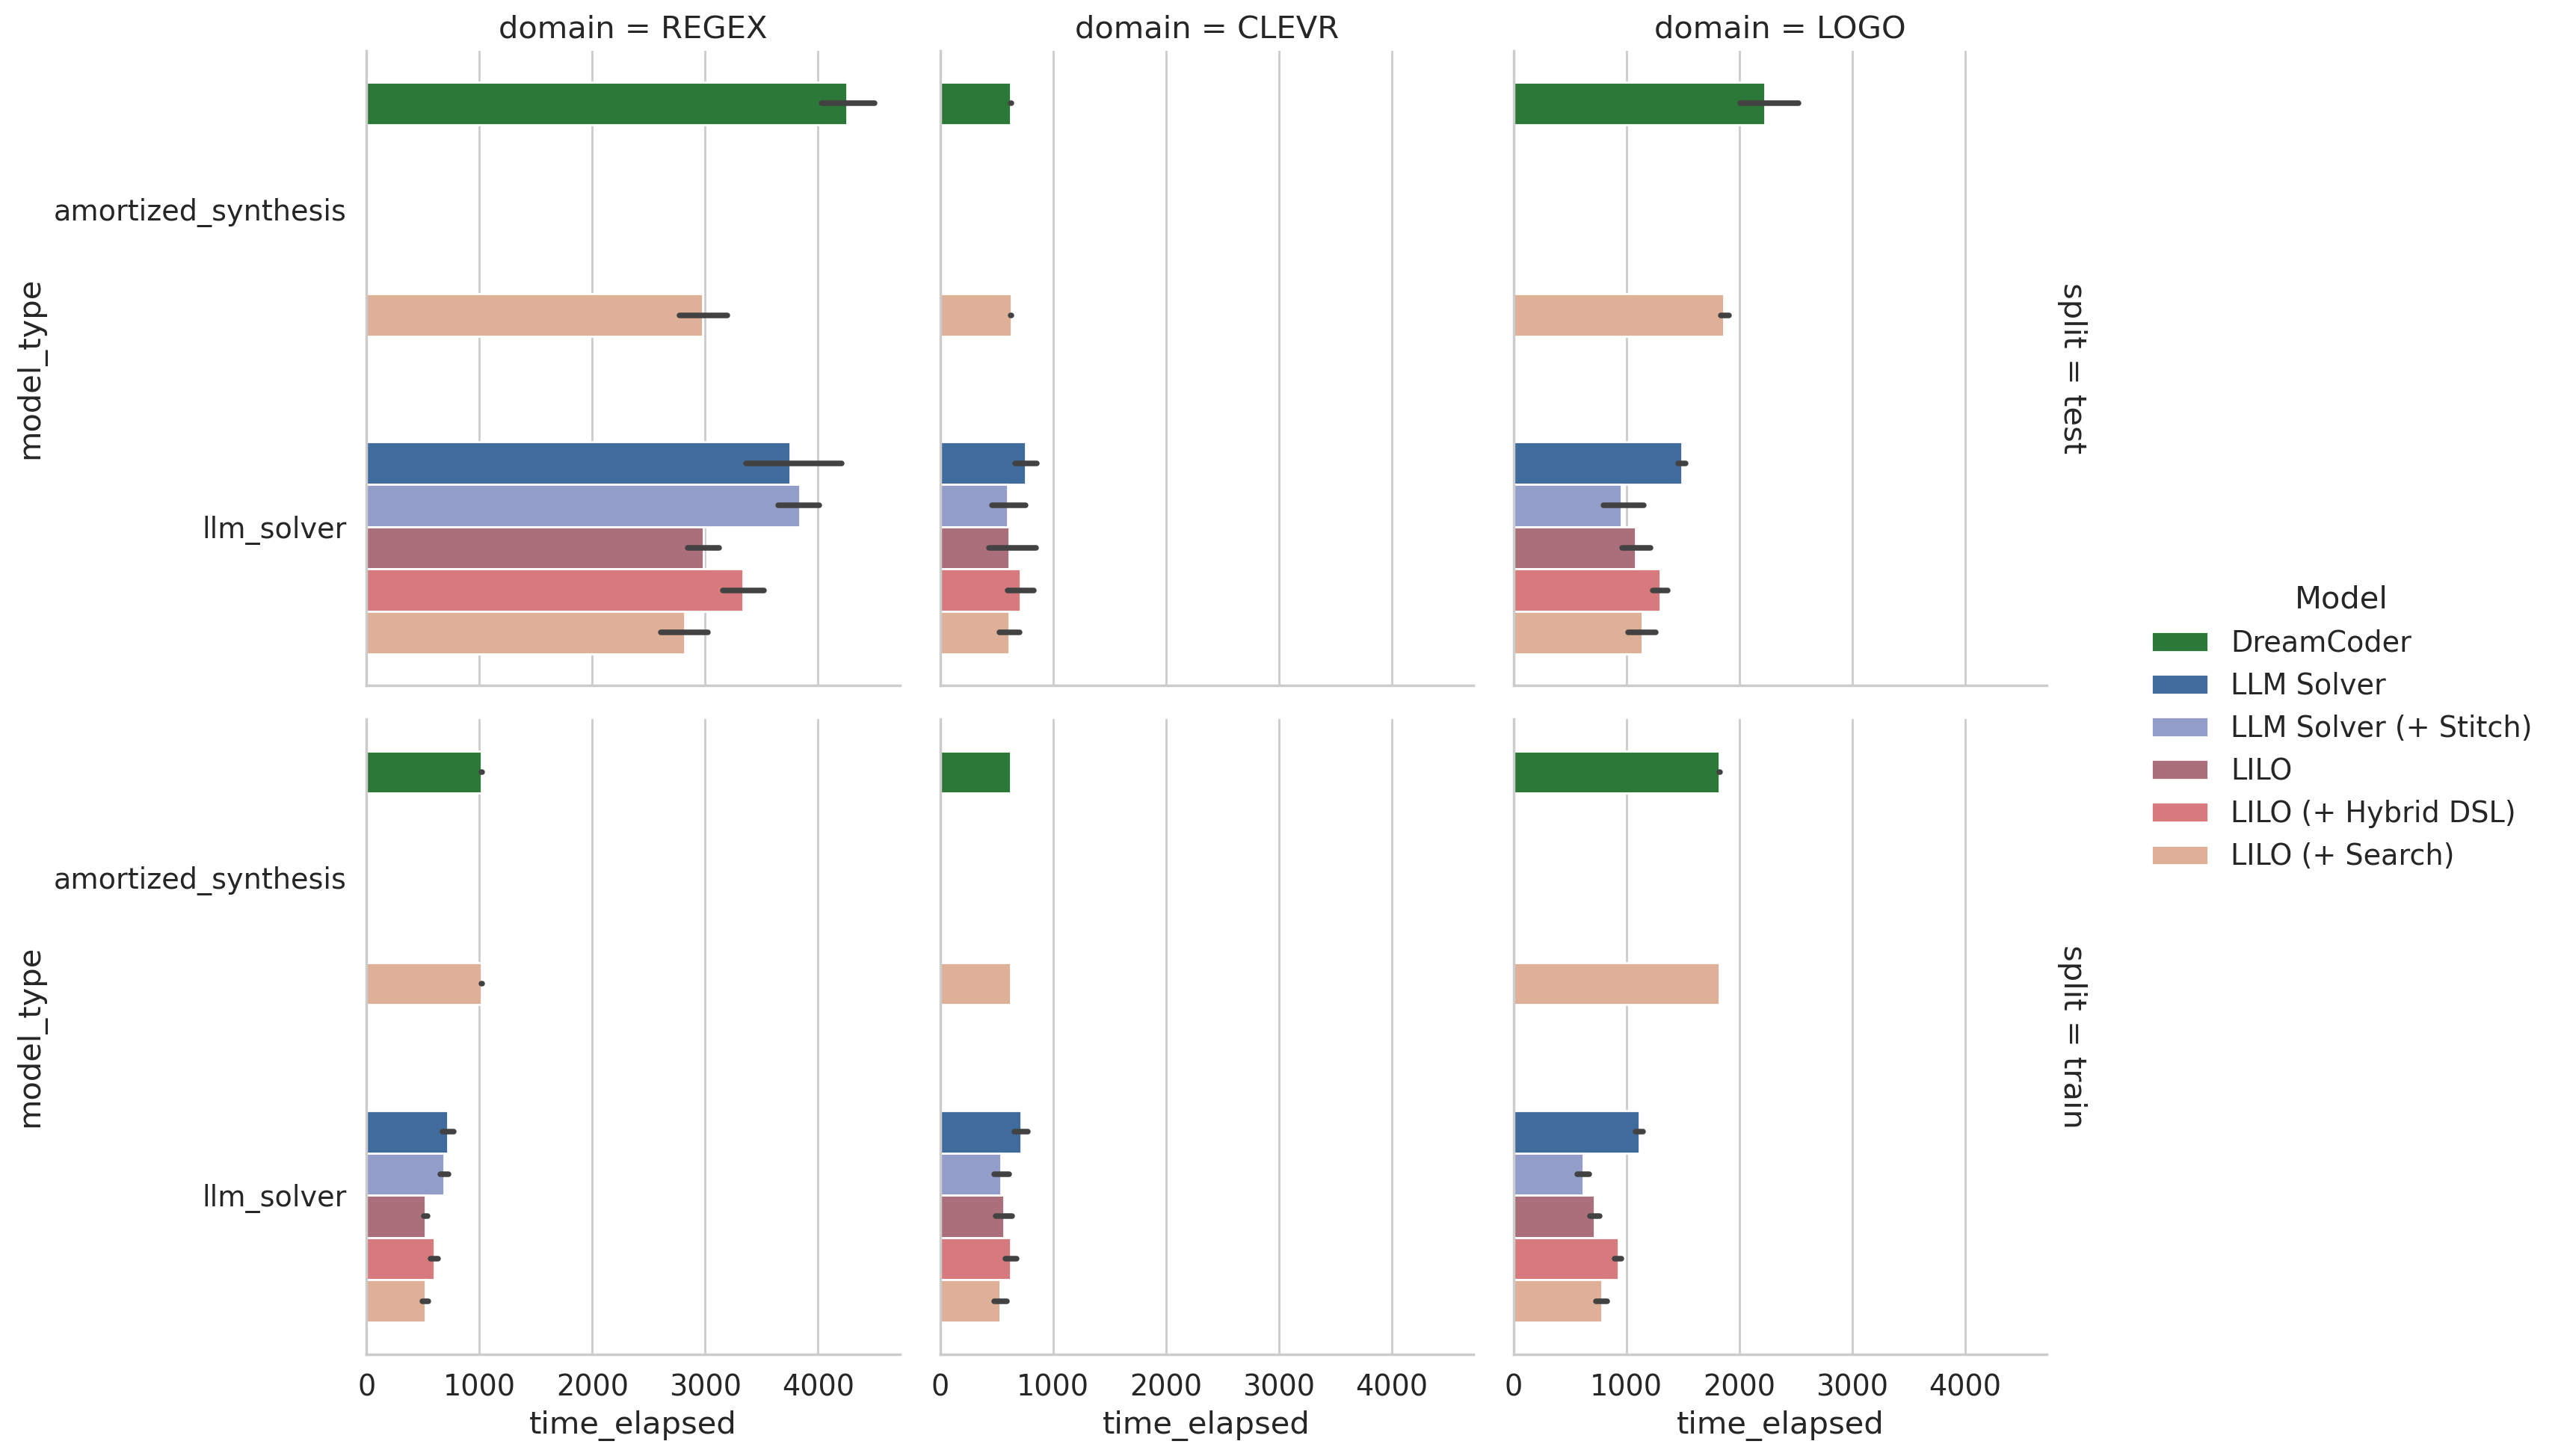

In [76]:
sns.catplot(
    data=analyzer.format_dataframe_camera(df_infer_programs), 
    kind="bar",
    col="domain",
    row="split",
    y="model_type",
    x="time_elapsed", 
    hue=analyzer.COL_NAMES_CAMERA["experiment_type"],
    palette=analyzer.EXPERIMENT_TYPES_PALETTE,
    margin_titles=True,
    sharex=True,
    # facet_kws=dict(sharex=True,)
    
)

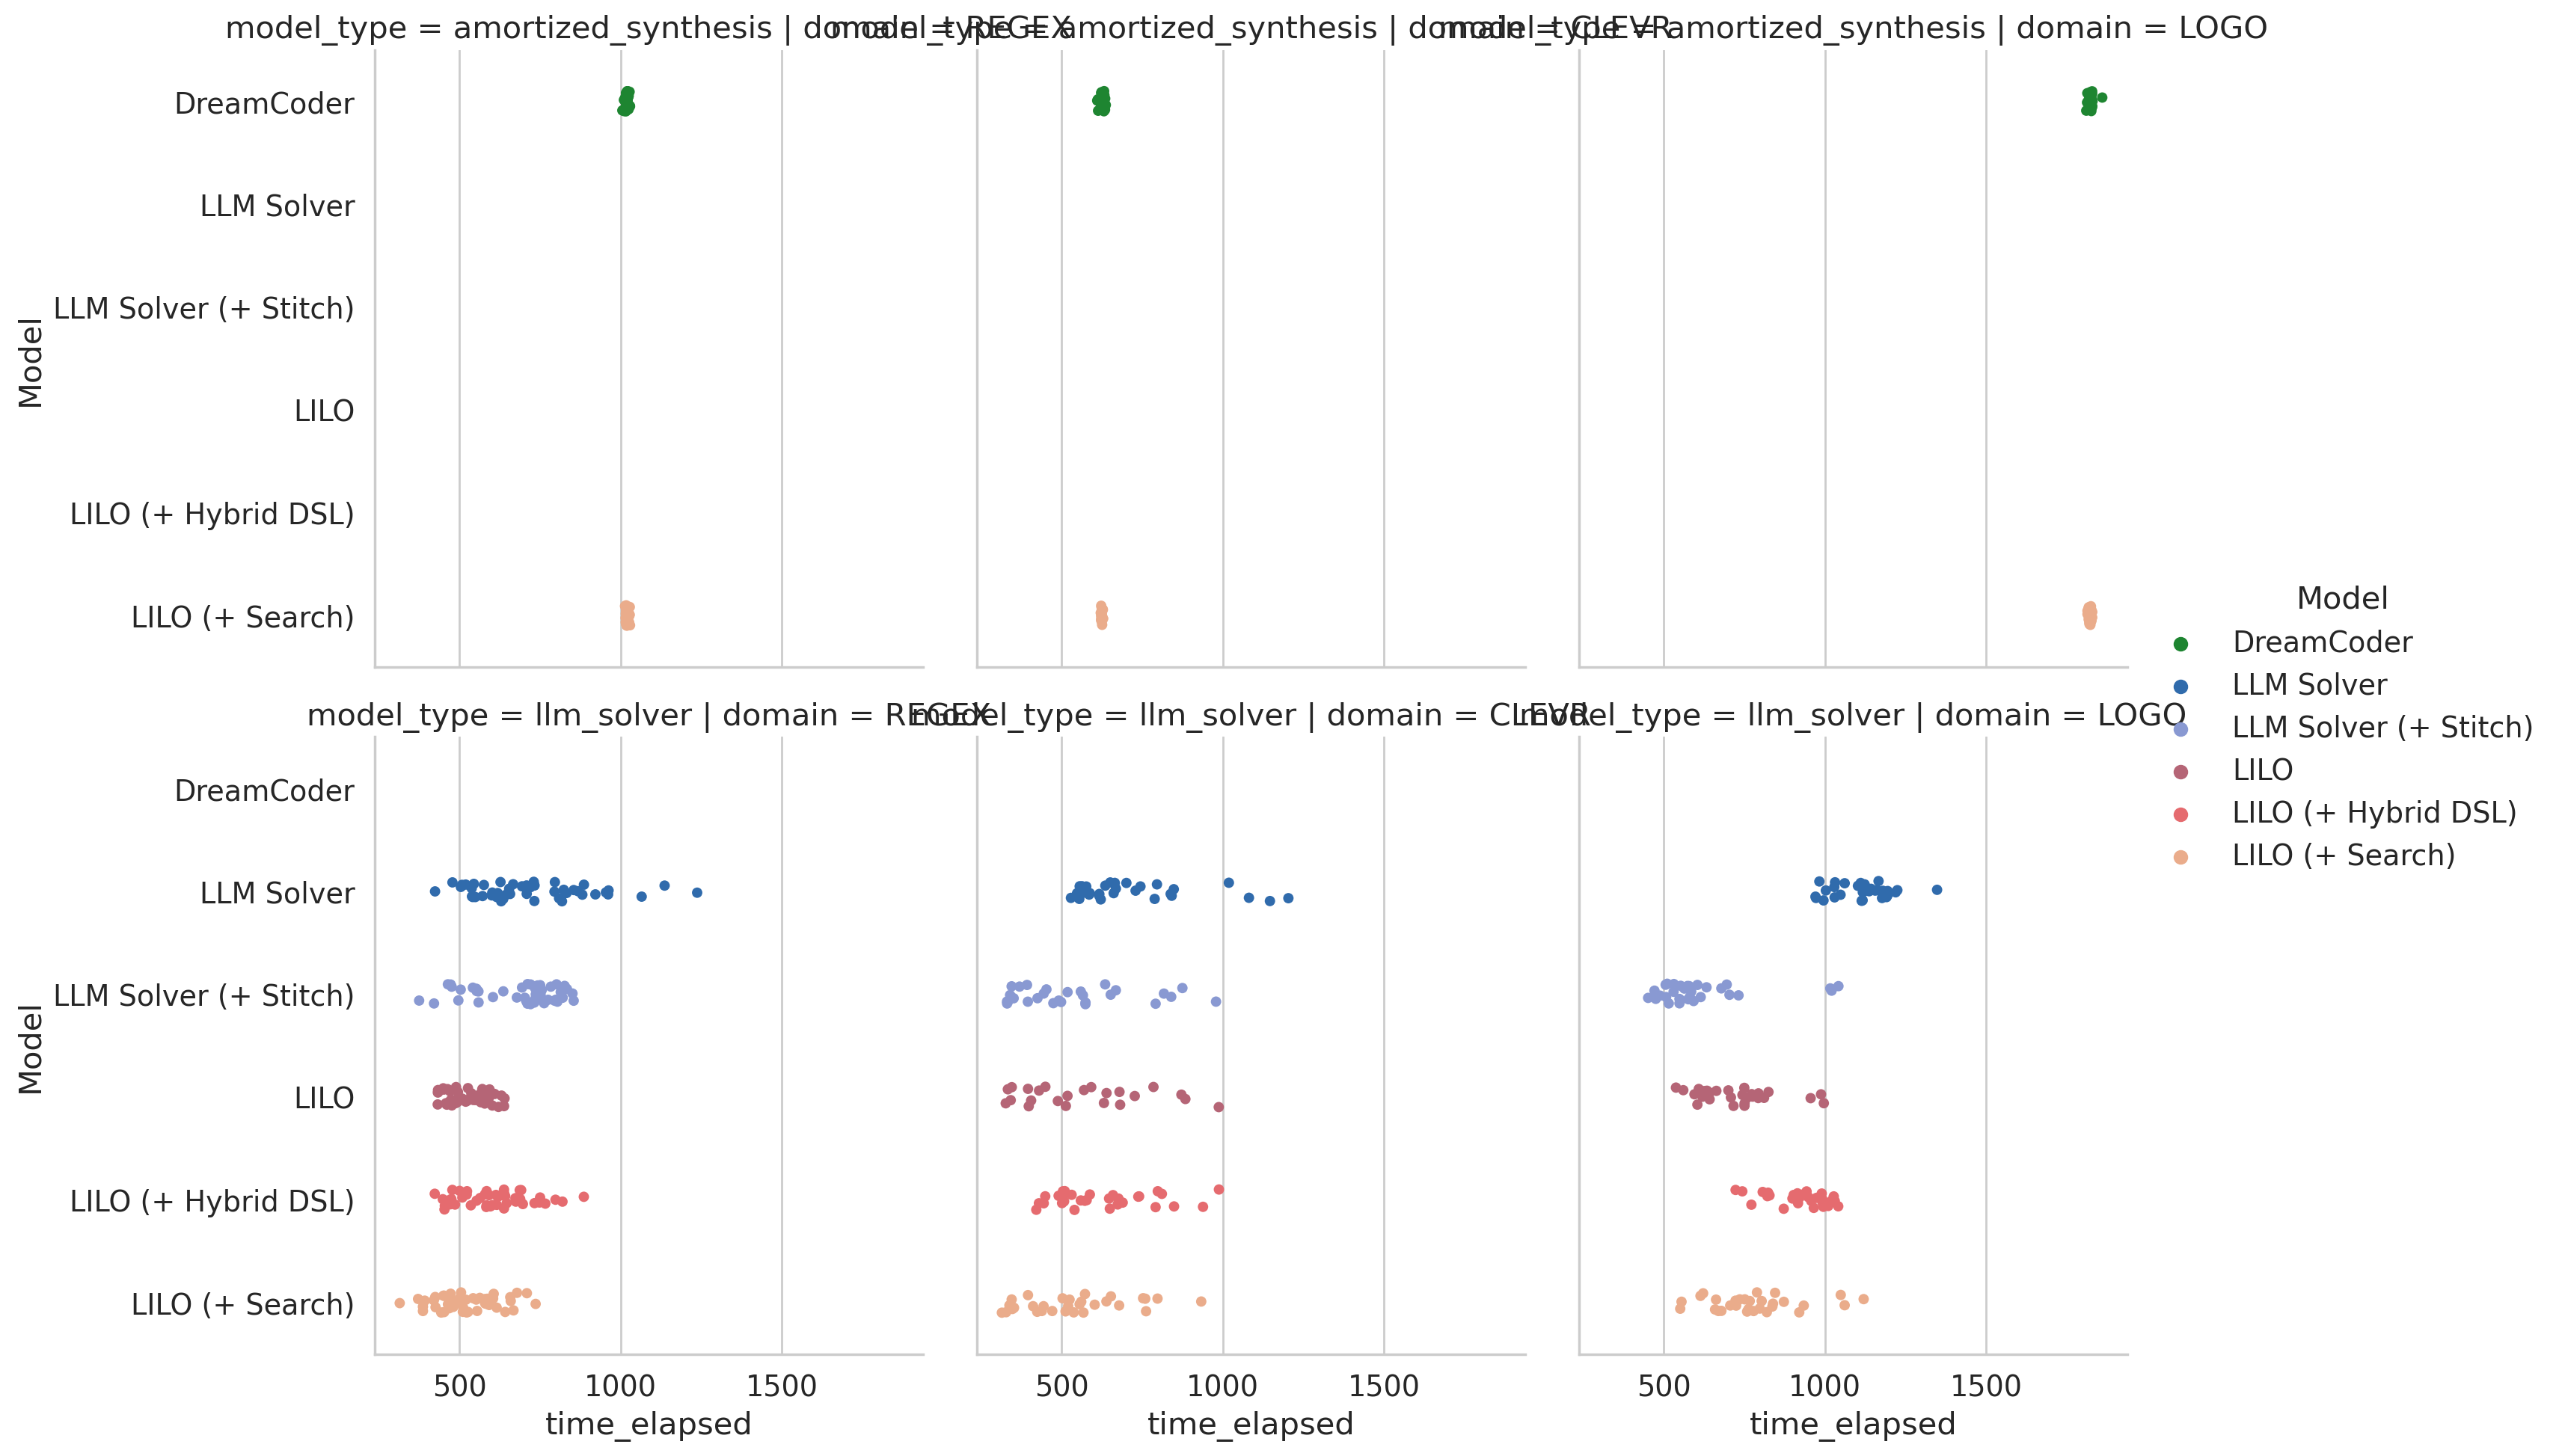

In [77]:
sns.catplot(
    data=analyzer.format_dataframe_camera(df_infer_programs.query("split == 'train'")), 
    kind="strip",
    col="domain",
    row="model_type",
    y=analyzer.COL_NAMES_CAMERA["experiment_type"],
    x="time_elapsed", 
    hue=analyzer.COL_NAMES_CAMERA["experiment_type"],
    palette=analyzer.EXPERIMENT_TYPES_PALETTE,
    margin_titles=True,
    sharex=True,
    # facet_kws=dict(sharex=True,)
    
)

# Number of queries

In [78]:
# Cache these results since they take a long time to load
TOKEN_USAGE_PATH = "token_usage.csv"

if not os.path.exists(TOKEN_USAGE_PATH):
    df_token_usage = analyzer.get_gpt_solver_results()
    df_token_usage.to_csv("token_usage.csv", index=False)
else:
    df_token_usage = pd.read_csv(TOKEN_USAGE_PATH)

In [79]:
df_token_usage

,prompt_tokens,completion_tokens,total_tokens,domain,experiment_type,seed,iteration,split,task_id,query_i
0,1460,206,1666,re2,gpt_solver,111,0,train,re2_train_489_if_there_is_any_letter_consonant...,0
1,1463,195,1658,re2,gpt_solver,111,0,train,re2_train_489_if_there_is_any_letter_consonant...,1
2,1462,232,1694,re2,gpt_solver,111,0,train,re2_train_489_if_there_is_any_letter_consonant...,2
3,1460,183,1643,re2,gpt_solver,111,0,train,re2_train_489_if_there_is_any_letter_consonant...,3
4,1461,184,1645,re2,gpt_solver,111,0,train,re2_train_153_if_there_is_consonant_consonant_...,0
...,...,...,...,...,...,...,...,...,...,...
279039,3882,338,4220,logo,gpt_solver_stitch_namer_search,333,9,test,6 sided snowflake with a short space and a sho...,3
279040,3935,151,4086,logo,gpt_solver_stitch_namer_search,333,9,test,5 sided snowflake with 2 small 5 gon s as arms,0
279041,3830,222,4052,logo,gpt_solver_stitch_namer_search,333,9,test,5 sided snowflake with 2 small 5 gon s as arms,1
279042,3767,374,4141,logo,gpt_solver_stitch_namer_search,333,9,test,5 sided snowflake with 2 small 5 gon s as arms,2


In [80]:
df_token_usage_by_iteration = df_token_usage.groupby([
    "domain",
    "experiment_type",
    "split",
    "seed",
    "iteration"
]) \
[["prompt_tokens", "completion_tokens", "total_tokens"]] \
.sum().reset_index()

df_token_usage_by_iteration

,domain,experiment_type,split,seed,iteration,prompt_tokens,completion_tokens,total_tokens
0,clevr,gpt_solver,test,111,0,1290850,87360,1378210
1,clevr,gpt_solver,test,111,3,770686,76143,846829
2,clevr,gpt_solver,test,111,6,660547,82898,743445
3,clevr,gpt_solver,test,111,9,582015,78061,660076
4,clevr,gpt_solver,test,222,0,1161136,70582,1231718
...,...,...,...,...,...,...,...,...
745,re2,gpt_solver_stitch_namer_search,train,333,11,916229,37347,953576
746,re2,gpt_solver_stitch_namer_search,train,333,12,749141,29384,778525
747,re2,gpt_solver_stitch_namer_search,train,333,13,787686,34425,822111
748,re2,gpt_solver_stitch_namer_search,train,333,14,880818,36147,916965


In [81]:
analyzer.format_dataframe_camera(df_token_usage_by_iteration.query("split == 'train'"))

,domain,Model,split,seed,iteration,prompt_tokens,completion_tokens,total_tokens
438,REGEX,LLM Solver,train,111,0,420499,58326,478825
439,REGEX,LLM Solver,train,111,1,763250,67007,830257
440,REGEX,LLM Solver,train,111,2,960253,72747,1033000
441,REGEX,LLM Solver,train,111,3,984600,77153,1061753
442,REGEX,LLM Solver,train,111,4,839914,70389,910303
...,...,...,...,...,...,...,...,...
415,LOGO,LILO (+ Search),train,333,5,1162170,78290,1240460
416,LOGO,LILO (+ Search),train,333,6,1047793,60812,1108605
417,LOGO,LILO (+ Search),train,333,7,1055473,67768,1123241
418,LOGO,LILO (+ Search),train,333,8,791713,40193,831906


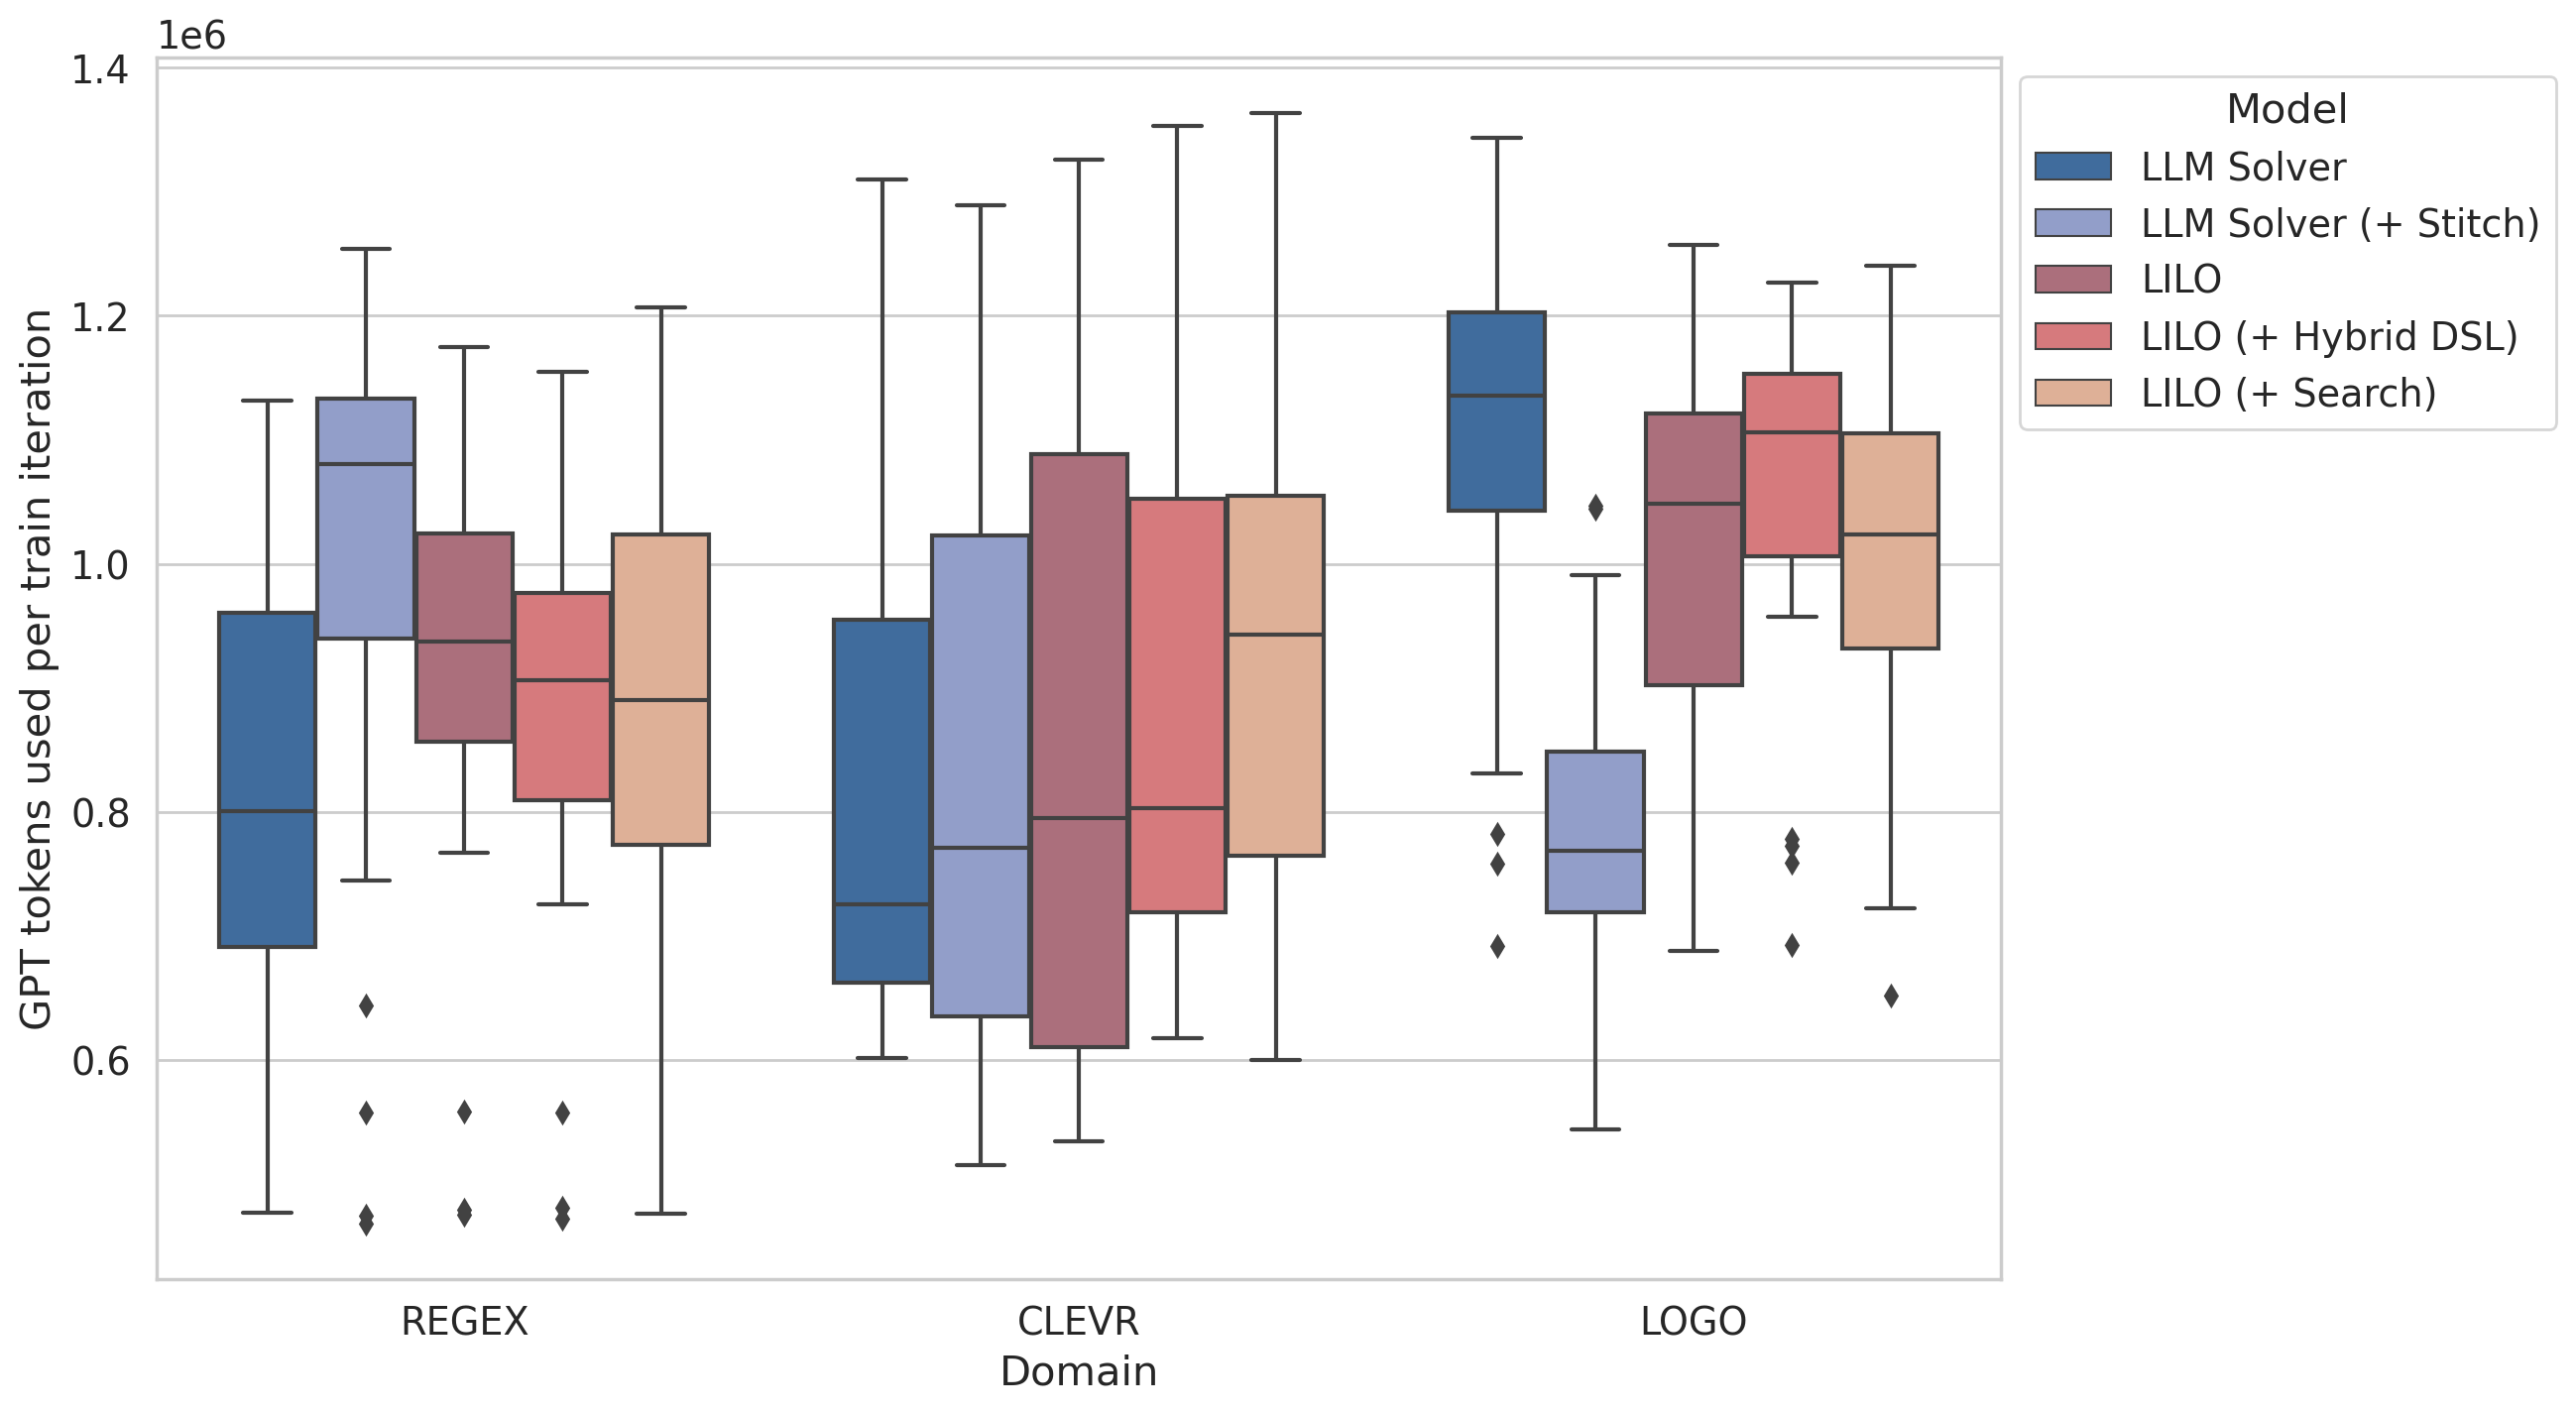

In [88]:
ax = sns.boxplot(
    data=analyzer.format_dataframe_camera(df_token_usage_by_iteration.query("split == 'train'")), 
    y="total_tokens",
    x="domain",
    hue=analyzer.COL_NAMES_CAMERA["experiment_type"],
    palette=analyzer.EXPERIMENT_TYPES_PALETTE,
)
ax.set_ylabel("GPT tokens used per train iteration")
ax.set_xlabel("Domain")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.savefig(os.path.join(FIGURES_DIR, "token_usage.pdf"), dpi=300, bbox_inches="tight")

# Dollar cost table

In [83]:
df_token_usage_stats = df_token_usage.query("split == 'train'").groupby([
    "domain",
    "experiment_type",
    "seed",
    "iteration"
]) \
[["total_tokens"]] \
.sum().reset_index()

df_token_usage_stats = df_token_usage_stats.groupby([
    "domain",
    "experiment_type",
]) \
[["total_tokens"]] \
.agg(["mean", "std"]).reset_index()

df_token_usage_stats[("cost", "mean")] = (0.002 / 1000) * df_token_usage_stats["total_tokens"]["mean"]
df_token_usage_stats[("cost", "std")] = (0.002 / 1000) * df_token_usage_stats["total_tokens"]["std"]

# Drop total tokens
df_token_usage_stats = df_token_usage_stats[["domain", "experiment_type", "cost"]]

df_token_usage_stats

domain                     experiment_type      cost          
                                                   mean       std
0   clevr                          gpt_solver  1.662261  0.435939
1   clevr                   gpt_solver_stitch  1.662688  0.471845
2   clevr             gpt_solver_stitch_namer  1.701005  0.521042
3   clevr  gpt_solver_stitch_namer_hybrid_dsl  1.779008  0.427517
4   clevr      gpt_solver_stitch_namer_search  1.865970  0.418131
5    logo                          gpt_solver  2.193114  0.317582
6    logo                   gpt_solver_stitch  1.585315  0.240222
7    logo             gpt_solver_stitch_namer  2.029652  0.310121
8    logo  gpt_solver_stitch_namer_hybrid_dsl  2.118082  0.289716
9    logo      gpt_solver_stitch_namer_search  2.011322  0.297350
10    re2                          gpt_solver  1.646017  0.349959
11    re2                   gpt_solver_stitch  2.038254  0.392807
12    re2             gpt_solver_stitch_namer  1.856264  0.303634
13    re2  gpt_solver_stitch_namer_hybrid_dsl  1.781908  0.300268
14    re2      gpt_solver_stitch_namer_search  1.766567  0.376823

In [84]:
# Convert to table
df_token_usage_stats_table = analyzer.format_dataframe_camera(df_token_usage_stats)


df_token_usage_stats_table = df_token_usage_stats_table.pivot(index=analyzer.COL_NAMES_CAMERA["experiment_type"], columns="domain")

df_token_usage_stats_table = df_token_usage_stats_table.reorder_levels(order=[0, 2, 1], axis="columns")

multiindex = df_token_usage_stats_table.columns
multiindex = multiindex.reindex(list(analyzer.DOMAIN_NAMES_CAMERA.values()), level=1)[0]
multiindex = multiindex.reindex(["mean", "std"], level=2)[0]

df_token_usage_stats_table = df_token_usage_stats_table.reindex(columns=multiindex)
df_token_usage_stats_table.columns.names = [None, None, None]

# Reorder rows
experiment_types = [x for x in analyzer.EXPERIMENT_TYPES_CAMERA.values() if x in df_token_usage_stats_table.index]
df_token_usage_stats_table = df_token_usage_stats_table.reindex(experiment_types)

# Remove 'Model'
df_token_usage_stats_table.index.name = None

# Round numbers
df_token_usage_stats_table = df_token_usage_stats_table.round(2)

# Drop 'cost'
# df_token_usage_stats_table = df_token_usage_stats_table.droplevel(level=0, axis=1)

# Format each entry as a dollar value
df_token_usage_stats_table = df_token_usage_stats_table.applymap(lambda x: '${:,.2f}'.format(x) if isinstance(x, (int, float)) else x)


# Output to LaTeX
df_token_usage_stats_table.to_latex(os.path.join(FIGURES_DIR, "token_cost_table.tex"))

df_token_usage_stats_table

cost                                   
                       REGEX         CLEVR          LOGO       
                        mean    std   mean    std   mean    std
LLM Solver             $1.65  $0.35  $1.66  $0.44  $2.19  $0.32
LLM Solver (+ Stitch)  $2.04  $0.39  $1.66  $0.47  $1.59  $0.24
LILO                   $1.86  $0.30  $1.70  $0.52  $2.03  $0.31
LILO (+ Hybrid DSL)    $1.78  $0.30  $1.78  $0.43  $2.12  $0.29
LILO (+ Search)        $1.77  $0.38  $1.87  $0.42  $2.01  $0.30

In [85]:
df_search_stats = df_infer_programs \
.query("experiment_type == 'baseline_dreamcoder' or experiment_type == 'gpt_solver_stitch_namer_search'") \
.query("split == 'train'") \
.query("model_type == 'amortized_synthesis'") \
[["domain", "experiment_type", "seed", "iteration", "time_elapsed"]]

df_search_stats = df_search_stats.groupby([
    "domain",
    "experiment_type",
]) \
[["time_elapsed"]] \
.agg(["mean", "std"]).reset_index()

df_search_stats[("cost", "mean")] = (4.08 / (60*60)) * df_search_stats["time_elapsed"]["mean"]
df_search_stats[("cost", "std")] = (4.08 / (60*60)) * df_search_stats["time_elapsed"]["std"]

# Drop elapsed time
df_search_stats = df_search_stats[["domain", "experiment_type", "cost"]]


df_search_stats

domain                 experiment_type      cost          
                                              mean       std
0  clevr             baseline_dreamcoder  0.709911  0.007381
1  clevr  gpt_solver_stitch_namer_search  0.708299  0.002152
2   logo             baseline_dreamcoder  2.068901  0.009300
3   logo  gpt_solver_stitch_namer_search  2.065819  0.004783
4    re2             baseline_dreamcoder  1.156587  0.005212
5    re2  gpt_solver_stitch_namer_search  1.156620  0.004268

In [86]:
# Convert to table
df_search_stats_table = analyzer.format_dataframe_camera(df_search_stats)


df_search_stats_table = df_search_stats_table.pivot(index=analyzer.COL_NAMES_CAMERA["experiment_type"], columns="domain")

df_search_stats_table = df_search_stats_table.reorder_levels(order=[0, 2, 1], axis="columns")

multiindex = df_search_stats_table.columns
multiindex = multiindex.reindex(list(analyzer.DOMAIN_NAMES_CAMERA.values()), level=1)[0]
multiindex = multiindex.reindex(["mean", "std"], level=2)[0]

df_search_stats_table = df_search_stats_table.reindex(columns=multiindex)
df_search_stats_table.columns.names = [None, None, None]

# Reorder rows
experiment_types = [x for x in analyzer.EXPERIMENT_TYPES_CAMERA.values() if x in df_search_stats_table.index]
df_search_stats_table = df_search_stats_table.reindex(experiment_types)

# Remove 'Model'
df_search_stats_table.index.name = None

# Round numbers
df_search_stats_table = df_search_stats_table.round(2)

# Drop 'cost'
# df_search_stats_table = df_search_stats_table.droplevel(level=0, axis=1)

# Format each entry as a dollar value
df_search_stats_table = df_search_stats_table.applymap(lambda x: '${:,.2f}'.format(x) if isinstance(x, (int, float)) else x)


# Output to LaTeX
df_search_stats_table.to_latex(os.path.join(FIGURES_DIR, "search_cost_table.tex"))

df_search_stats_table

cost                                   
                 REGEX         CLEVR          LOGO       
                  mean    std   mean    std   mean    std
DreamCoder       $1.16  $0.01  $0.71  $0.01  $2.07  $0.01
LILO (+ Search)  $1.16  $0.00  $0.71  $0.00  $2.07  $0.00

In [87]:
df_cost_table = pd.concat([df_token_usage_stats_table, df_search_stats_table], keys=['LLM Search', 'Enumerative Search'])

# Output to LaTeX
df_cost_table.to_latex(os.path.join(FIGURES_DIR, "cost_table.tex"))

df_cost_table

cost                              \
                                          REGEX         CLEVR          LOGO   
                                           mean    std   mean    std   mean   
LLM Search         LLM Solver             $1.65  $0.35  $1.66  $0.44  $2.19   
                   LLM Solver (+ Stitch)  $2.04  $0.39  $1.66  $0.47  $1.59   
                   LILO                   $1.86  $0.30  $1.70  $0.52  $2.03   
                   LILO (+ Hybrid DSL)    $1.78  $0.30  $1.78  $0.43  $2.12   
                   LILO (+ Search)        $1.77  $0.38  $1.87  $0.42  $2.01   
Enumerative Search DreamCoder             $1.16  $0.01  $0.71  $0.01  $2.07   
                   LILO (+ Search)        $1.16  $0.00  $0.71  $0.00  $2.07   

                                                 
                                                 
                                            std  
LLM Search         LLM Solver             $0.32  
                   LLM Solver (+ Stitch)  $0.24  
                   LILO                   $0.31  
                   LILO (+ Hybrid DSL)    $0.29  
                   LILO (+ Search)        $0.30  
Enumerative Search DreamCoder             $0.01  
                   LILO (+ Search)        $0.00